# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [69]:
import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from tyssue import Epithelium
from tyssue import BulkGeometry

from tyssue.core.generation import three_faces_sheet
from tyssue.core.generation import extrude
from tyssue.draw.threejs_draw import view_3js


datasets_2d, specs = three_faces_sheet()
datasets = extrude(datasets_2d, method='translation')
eptm = Epithelium('3faces_3D', datasets)
BulkGeometry.update_all(eptm)


class RNRGeometry(BulkGeometry):
    
    @staticmethod
    def update_centroid(eptm):

        srce_pos = eptm.upcast_srce(eptm.vert_df[eptm.coords])
        trgt_pos = eptm.upcast_trgt(eptm.vert_df[eptm.coords])
        mid_pos = (srce_pos + trgt_pos)/2
        eptm.face_df[eptm.coords] = (eptm.sum_face(mid_pos).values /
                                     eptm.face_df['perimeter'].values[:, np.newaxis])
        srce_pos['cell'] = eptm.edge_df['cell']
        eptm.cell_df[eptm.coords] = srce_pos.groupby('cell').mean()
        

In [71]:
eptm.edge_df.head()

,face,nx,dy,nz,trgt,ny,srce,dz,dx,length,segment,cell,sub_area,sub_vol
edge,,,,,,,,,,,,,,
0,0,-0.0,0.000,0.866,1,0.0,0,0.0,1.0,1.000000,apical,0,0.433,0.072167
1,0,-0.0,0.866,0.866,2,0.0,1,0.0,0.5,0.999978,apical,0,0.433,0.072167
2,0,0.0,0.866,0.866,3,-0.0,2,0.0,-0.5,0.999978,apical,0,0.433,0.072167
3,0,0.0,0.000,0.866,4,-0.0,3,0.0,-1.0,1.000000,apical,0,0.433,0.072167
4,0,0.0,-0.866,0.866,5,0.0,4,0.0,-0.5,0.999978,apical,0,0.433,0.072167


In [13]:

RNRGeometry.update_all(eptm)

In [4]:
render, line = view_3js(eptm)
display(render)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [14]:
RNRGeometry.update_all(eptm)
face_pos = eptm.face_df[eptm.coords].values

BulkGeometry.update_all(eptm)
np.testing.assert_almost_equal(eptm.face_df[eptm.coords].values,
                               face_pos, decimal=4)

In [83]:
from tyssue import Sheet

In [95]:
sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
BulkGeometry.update_all(eptm)
RNRGeometry.update_all(eptm)



In [96]:
render, line = view_3js(eptm)
display(render)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## I→H transition

![IH transition in a bulk and a monolayer](../data/png/IH_transition.png)



In [ ]:
from tyssue.topology.bulk_topology import add_vert

In [75]:
srce_orbits = eptm.get_orbits('srce', 'face')

In [76]:
srce_orbits.head()

srce  edge
0     0        0
      6        1
      12       2
      37       6
      56      11
Name: face, dtype: int64

In [77]:
def IH_transition(eptm, e_1011):
    
    v_pairs, common_faces = get_vertex_pairs(eptm, e_1011)
    try:
        (v1, v4), (v2, v5), (v3, v6) = v_pairs
    except ValueError:
        print('Edge {} is not a valid junction to'
              ' perform IH transition on, aborting'.format(e_1011))
        return
    new_vs = eptm.vert_df.loc[[v1, v2, v3]].copy()
    eptm.vert_df.append(new_vs, ignore_index=True)
    v7, v8, v9 = eptm.vert_df.index[-3:]
    for pair, new in zip(v_pairs, (v7, v8, v9)):
        
        va, vb = pair
        e_a10s = eptm.edge_df[(eptm.edge_df['srce'] == va) &
                              (eptm.edge_df['trgt'] == v10)].index
        eptm.edge_df.loc[e_a10s, 'trgt'] = new

        e_10as = eptm.edge_df[(eptm.edge_df['srce'] == v10) &
                              (eptm.edge_df['trgt'] == va)].index
        eptm.edge_df.loc[e_10as, 'srce'] = new
        
        e_b11s = eptm.edge_df[(eptm.edge_df['srce'] == vb) &
                              (eptm.edge_df['trgt'] == v11)].index
        eptm.edge_df.loc[e_b11s, 'trgt'] = new

        e_11bs = eptm.edge_df[(eptm.edge_df['srce'] == v11) &
                              (eptm.edge_df['trgt'] == vb)].index
        eptm.edge_df.loc[e_11bs, 'srce'] = new
        
    
    
    
    
    
def get_vertex_pairs(eptm, e_1011):
    
    srce_orbits = eptm.get_orbits('srce', 'face')
        
    v10, v11 = eptm.edge_df.loc[e_1011, ['srce', 'trgt']]
    v10_out = set(eptm.edge_df[eptm.edge_df['srce']==v10]['trgt']) - {v11}
    faces_123 = {v: frozenset(srce_orbits.loc[v])
                 for v in v10_out}
    
    v11_out = set(eptm.edge_df[eptm.edge_df['srce']==v11]['trgt']) - {v10}
    faces_456 = {v: frozenset(srce_orbits.loc[v])
                 for v in v11_out}
    v_pairs = []
    common_faces = []
    for vi in v10_out:
        for vj in v11_out:
            common_face = faces_123[vi].intersection(faces_456[vj])
            if len(common_face) > 0:
                v_pairs.append((vi, vj))
                common_faces.append(common_face)
                break
        else:
            raise ValueError('No vertex for vertex %i' % vi)
    return v_pairs, common_faces
    
    

In [81]:
from tyssue.draw.plt_draw import quick_edge_draw

In [102]:
edge = 56
IH_transition(eptm, edge, srce_orbits=None)

[(24, 28), (33, 29), (69, 66)]

(<matplotlib.figure.Figure at 0x7f8988d8e9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8988d8b550>)

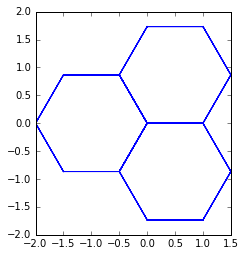

In [82]:
quick_edge_draw(eptm, )